# Explor and prepare the data
## Descriptive Analysis for Car Accidents in Washington D.C
### Zaid Altukhi
### DR. LIAO, PH.D.
George Mason University
| AIT 614: Big Data Essentials


# Import libraries and packages

In [2]:
import numpy as np
import pandas as pd
import altair as alt
alt.data_transformers.enable('default', max_rows=None)

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from warnings import filterwarnings
filterwarnings('ignore')
from scipy import stats


In [4]:
df = pd.read_csv('/Volumes/LOVUN/George Mason Files/Fall 2021/AIT 614/project/data/oct29_datasset.csv')

# Import the data

In [3]:
fulldata = pd.read_csv('/Volumes/LOVUN/George Mason Files/Fall 2021/AIT 614/project/data/Crashes_in_DC.csv')

# Clean and prepare The data

## Drop unrelated columns

In [4]:
fulldata=fulldata.drop(['TODATE',
              'STREETSEGID',
              'ROADWAYSEGID',
              'WARD',
              'MAR_SCORE',
              'STREETSEGID',
              'LASTUPDATEDATE',
              'MPDGEOY',
              'MPDGEOX',
              'LOCATIONERROR',
              'LASTUPDATEDATE',
              'MPDLATITUDE',
              'MPDLONGITUDE',
              'MPDGEOX',
              'MPDGEOY',
              'MAR_ADDRESS'], axis=1)

#### Drop empty columns

In [5]:
fulldata=fulldata.drop(['BLOCKKEY',
              'SUBBLOCKKEY'], axis=1)

## Add columns

### Aggregate columns

In [6]:
fulldata['TOTAL_FATAL'] = fulldata.apply(lambda row: row.FATAL_DRIVER + row.FATAL_BICYCLIST + row.FATAL_PEDESTRIAN + row.FATALPASSENGER, axis=1)
fulldata['TOTAL_MAJORINJURIES']= fulldata.apply(lambda row: row.MAJORINJURIES_BICYCLIST + row.MAJORINJURIES_DRIVER + row.MAJORINJURIES_PEDESTRIAN + row.MAJORINJURIESPASSENGER, axis=1)
fulldata['TOTAL_MINORINJURIES']= fulldata.apply(lambda row: row.MINORINJURIES_BICYCLIST + row.MINORINJURIES_DRIVER + row.MINORINJURIES_PEDESTRIAN + row.MINORINJURIESPASSENGER , axis=1)
fulldata['TOTAL_UNKNOWNINJURIES']= fulldata.apply(lambda row: row.UNKNOWNINJURIES_BICYCLIST + row.UNKNOWNINJURIES_DRIVER + row.UNKNOWNINJURIES_PEDESTRIAN + row.UNKNOWNINJURIESPASSENGER, axis=1)
fulldata['TOTAL_ACCEIDENTELEMENTS']= fulldata.apply(lambda row: row.TOTAL_VEHICLES + row.TOTAL_BICYCLES + row.TOTAL_PEDESTRIANS + row.TOTAL_TAXIS + row.TOTAL_GOVERNMENT , axis=1)


In [8]:
fulldata['FATAL'] = np.where(fulldata['TOTAL_FATAL']>= 1, 1, 0)

In [9]:
fulldata['TOTAL_INJURIES']= fulldata.apply(lambda row: row.TOTAL_MAJORINJURIES + row.TOTAL_MINORINJURIES + row.TOTAL_UNKNOWNINJURIES , axis=1)


In [10]:
fulldata['TOTAL_INJURIES_ELEMENTS']= fulldata.apply(lambda row: row.TOTAL_INJURIES + row.TOTAL_ACCEIDENTELEMENTS , axis=1)


### convert columns datatypes

#### convert date time

In [11]:
fulldata['REPORTDATE']= pd.to_datetime(fulldata['REPORTDATE'])
fulldata['FROMDATE']= pd.to_datetime(fulldata['FROMDATE'])

#### convert from int to object

In [12]:
fulldata['OBJECTID'] = fulldata['OBJECTID'].apply(str)
fulldata['CRIMEID'] = fulldata['CRIMEID'].apply(str)
fulldata['ROUTEID'] = fulldata['ROUTEID'].apply(str)
fulldata['MARID'] = fulldata['MARID'].apply(str)

# Fillter the data

## Get the records from 2009-2020

In [13]:
fulldata = fulldata[fulldata['REPORTDATE'].dt.year> 2008]
fulldata = fulldata[fulldata['REPORTDATE'].dt.year< 2021]

In [14]:
fulldata.groupby([pd.DatetimeIndex(fulldata['REPORTDATE']).year]).size()

REPORTDATE
2009    12014
2010    12141
2011    13290
2012    16747
2013    17481
2014    19383
2015    22332
2016    26563
2017    26476
2018    26538
2019    26795
2020    18294
dtype: int64

## Work with NAs 

There are 5 columns contain missing values, those will be removed

In [15]:
#Create a new function:
def num_missing(x):
  return sum(x.isnull())

#Applying per column:
print ("Missing values per column:")
print (fulldata.apply(num_missing, axis=0)) #axis=0 defines that function is to be applied on each column

#Applying per row:
print ("\nMissing values per row:")
print (fulldata.apply(num_missing, axis=1).head()) #axis=1 defines that function is to be applied on each row

Missing values per column:
X                              0
Y                              0
OBJECTID                       0
CRIMEID                        0
CCN                            0
REPORTDATE                     0
ROUTEID                        0
MEASURE                        0
OFFSET                         0
FROMDATE                       6
MARID                          0
ADDRESS                       80
LATITUDE                       9
LONGITUDE                      9
XCOORD                         0
YCOORD                         0
EVENTID                        3
MAJORINJURIES_BICYCLIST        0
MINORINJURIES_BICYCLIST        0
UNKNOWNINJURIES_BICYCLIST      0
FATAL_BICYCLIST                0
MAJORINJURIES_DRIVER           0
MINORINJURIES_DRIVER           0
UNKNOWNINJURIES_DRIVER         0
FATAL_DRIVER                   0
MAJORINJURIES_PEDESTRIAN       0
MINORINJURIES_PEDESTRIAN       0
UNKNOWNINJURIES_PEDESTRIAN     0
FATAL_PEDESTRIAN               0
TOTAL_VEHICLES  

## Drop the missing data

In [16]:
fulldata = fulldata[fulldata['ADDRESS'].notna()] #80
fulldata = fulldata[fulldata['FROMDATE'].notna()] #6
fulldata = fulldata[fulldata['LATITUDE'].notna()] #9
fulldata = fulldata[fulldata['LONGITUDE'].notna()] #9
fulldata = fulldata[fulldata['EVENTID'].notna()] #3


## Drop all accident with no injuries or accident elements

In [17]:
fulldata = fulldata[fulldata.TOTAL_INJURIES_ELEMENTS != 0]

In [18]:
fulldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237193 entries, 647 to 257970
Data columns (total 54 columns):
 #   Column                      Non-Null Count   Dtype              
---  ------                      --------------   -----              
 0   X                           237193 non-null  float64            
 1   Y                           237193 non-null  float64            
 2   OBJECTID                    237193 non-null  object             
 3   CRIMEID                     237193 non-null  object             
 4   CCN                         237193 non-null  object             
 5   REPORTDATE                  237193 non-null  datetime64[ns, UTC]
 6   ROUTEID                     237193 non-null  object             
 7   MEASURE                     237193 non-null  float64            
 8   OFFSET                      237193 non-null  float64            
 9   FROMDATE                    237193 non-null  datetime64[ns, UTC]
 10  MARID                       237193 non-nul

In [19]:
fulldata.describe()

,X,Y,MEASURE,OFFSET,LATITUDE,LONGITUDE,XCOORD,YCOORD,MAJORINJURIES_BICYCLIST,MINORINJURIES_BICYCLIST,...,MINORINJURIESPASSENGER,UNKNOWNINJURIESPASSENGER,TOTAL_FATAL,TOTAL_MAJORINJURIES,TOTAL_MINORINJURIES,TOTAL_UNKNOWNINJURIES,TOTAL_ACCEIDENTELEMENTS,FATAL,TOTAL_INJURIES,TOTAL_INJURIES_ELEMENTS
count,237193.000000,237193.000000,237193.000000,237193.000000,237193.000000,237193.000000,237193.000000,237193.000000,237193.000000,237193.000000,...,237193.000000,237193.000000,237193.000000,237193.000000,237193.000000,237193.000000,237193.000000,237193.000000,237193.000000,237193.000000
mean,-76.324041,38.422570,1012.497453,12.329332,38.904672,-77.007878,399260.300705,137423.659793,0.001615,0.010991,...,0.079994,0.009520,0.002007,0.109531,0.295856,0.076566,2.245682,0.001952,0.481954,2.727635
std,6.792604,4.780717,1553.376633,13.488095,0.030836,0.318286,3141.062430,3425.134140,0.040256,0.104705,...,0.378197,0.131995,0.045961,0.459874,0.656691,0.311264,0.663670,0.044138,0.838257,1.096224
min,-78.815503,-9.000001,0.000000,0.000000,38.805520,-77.114757,390050.862000,126708.403000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,-77.031964,38.887579,0.000000,0.060000,38.888558,-77.032265,397201.939000,135641.110000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2.000000
50%,-77.010270,38.904208,268.260000,6.990000,38.904479,-77.010897,399047.974000,137404.641000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,3.000000
75%,-76.984235,38.922301,1487.790000,21.550000,38.922524,-76.985293,401274.380000,139405.739000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,1.000000,3.000000
max,76.997681,40.000008,10660.870000,50.000000,38.994746,76.997665,407848.390000,147423.652000,2.000000,2.000000,...,17.000000,15.000000,2.000000,51.000000,19.000000,16.000000,17.000000,1.000000,51.000000,55.000000


In [20]:
#Binning:
def binning(col, cut_points, labels=None):
  #Define min and max values:
  minval = col.min()
  maxval = col.max()

  #create list by adding min and max to cut_points
  break_points = [minval] + cut_points + [maxval]

  #if no labels provided, use default labels 0 ... (n-1)
  if not labels:
    labels = range(len(cut_points)+1)

  #Binning using cut function of pandas
  colBin = pd.cut(col,bins=break_points,labels=labels,include_lowest=True)
  return colBin

#Binning age:
cut_points = [2,10,13,30]
labels = ['lowest',"low","medium","high",'extrem']
fulldata["Rate"] = binning(fulldata['TOTAL_INJURIES_ELEMENTS'], cut_points, labels)
print (pd.value_counts(fulldata["Rate"], sort=False))

lowest    115755
low       121254
medium       129
high          49
extrem         6
Name: Rate, dtype: int64


# Explore the data

In [21]:
fulldata[['TOTAL_FATAL','TOTAL_MAJORINJURIES','TOTAL_UNKNOWNINJURIES','TOTAL_ACCEIDENTELEMENTS','TOTAL_ACCEIDENTELEMENTS','TOTAL_INJURIES','TOTAL_INJURIES_ELEMENTS']].describe()

,TOTAL_FATAL,TOTAL_MAJORINJURIES,TOTAL_UNKNOWNINJURIES,TOTAL_ACCEIDENTELEMENTS,TOTAL_ACCEIDENTELEMENTS,TOTAL_INJURIES,TOTAL_INJURIES_ELEMENTS
count,237193.000000,237193.000000,237193.000000,237193.000000,237193.000000,237193.000000,237193.000000
mean,0.002007,0.109531,0.076566,2.245682,2.245682,0.481954,2.727635
std,0.045961,0.459874,0.311264,0.663670,0.663670,0.838257,1.096224
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,2.000000
50%,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,3.000000
75%,0.000000,0.000000,0.000000,3.000000,3.000000,1.000000,3.000000
max,2.000000,51.000000,16.000000,17.000000,17.000000,51.000000,55.000000


In [22]:
fulldata.groupby([pd.DatetimeIndex(fulldata['REPORTDATE']).year]).size()

REPORTDATE
2009    11982
2010    12138
2011    13265
2012    16682
2013    17418
2014    19225
2015    22220
2016    26470
2017    26381
2018    26471
2019    26711
2020    18230
dtype: int64

## Visualization

array([[<AxesSubplot:xlabel='TOTAL_FATAL', ylabel='TOTAL_FATAL'>,
        <AxesSubplot:xlabel='TOTAL_INJURIES', ylabel='TOTAL_FATAL'>,
        <AxesSubplot:xlabel='TOTAL_ACCEIDENTELEMENTS', ylabel='TOTAL_FATAL'>,
        <AxesSubplot:xlabel='TOTAL_INJURIES_ELEMENTS', ylabel='TOTAL_FATAL'>],
       [<AxesSubplot:xlabel='TOTAL_FATAL', ylabel='TOTAL_INJURIES'>,
        <AxesSubplot:xlabel='TOTAL_INJURIES', ylabel='TOTAL_INJURIES'>,
        <AxesSubplot:xlabel='TOTAL_ACCEIDENTELEMENTS', ylabel='TOTAL_INJURIES'>,
        <AxesSubplot:xlabel='TOTAL_INJURIES_ELEMENTS', ylabel='TOTAL_INJURIES'>],
       [<AxesSubplot:xlabel='TOTAL_FATAL', ylabel='TOTAL_ACCEIDENTELEMENTS'>,
        <AxesSubplot:xlabel='TOTAL_INJURIES', ylabel='TOTAL_ACCEIDENTELEMENTS'>,
        <AxesSubplot:xlabel='TOTAL_ACCEIDENTELEMENTS', ylabel='TOTAL_ACCEIDENTELEMENTS'>,
        <AxesSubplot:xlabel='TOTAL_INJURIES_ELEMENTS', ylabel='TOTAL_ACCEIDENTELEMENTS'>],
       [<AxesSubplot:xlabel='TOTAL_FATAL', ylabel='TOTAL_INJURIE

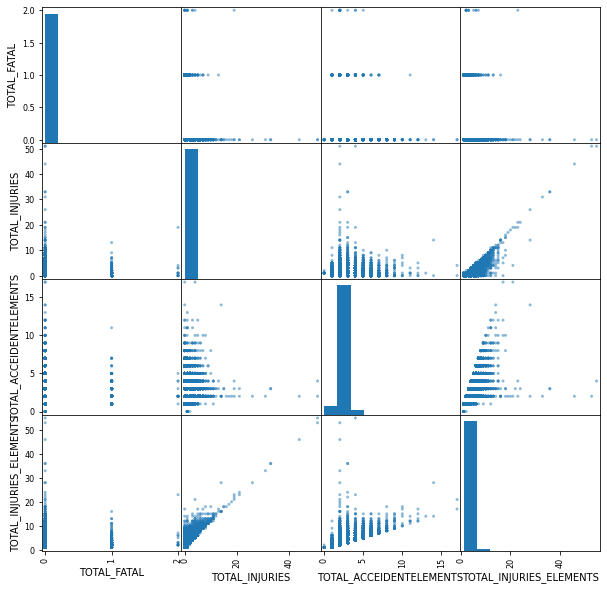

In [67]:
import pandas.plotting as pltt
pltt.scatter_matrix(fulldata[['TOTAL_FATAL','TOTAL_INJURIES', 'TOTAL_ACCEIDENTELEMENTS', 'TOTAL_INJURIES_ELEMENTS']], figsize= (10,10))   

<AxesSubplot:title={'center':'TOTAL_VEHICLES'}>

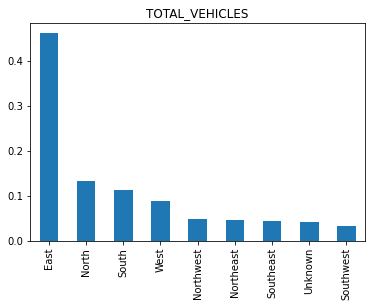

In [69]:
fulldata.INTAPPROACHDIRECTION.value_counts(normalize=True).plot(kind = 'bar', title = "TOTAL_VEHICLES")


<AxesSubplot:title={'center':'TOTAL_INJURIES_ELEMENTS'}, xlabel='INTAPPROACHDIRECTION'>

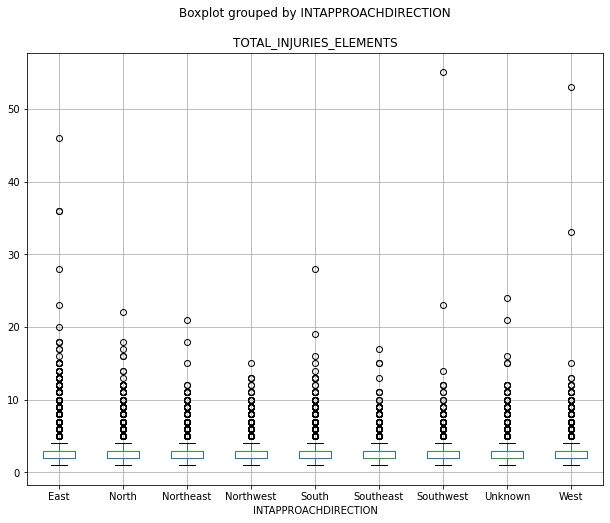

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline
fulldata.boxplot(column="TOTAL_INJURIES_ELEMENTS",by="INTAPPROACHDIRECTION", figsize=(10,8))

<AxesSubplot:title={'center':'TOTAL_ACCEIDENTELEMENTS'}, xlabel='DRIVERSIMPAIRED'>

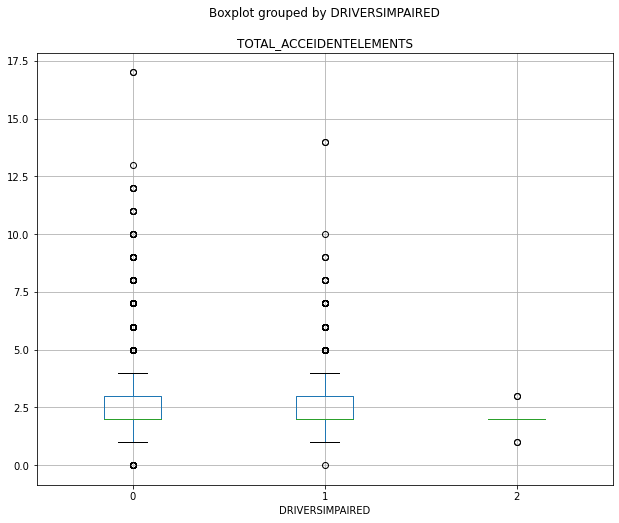

In [72]:
fulldata.boxplot(column="TOTAL_ACCEIDENTELEMENTS",by="DRIVERSIMPAIRED", figsize=(10,8))

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>],
       [<AxesSubplot:title={'center':'2'}>, <AxesSubplot:>]], dtype=object)

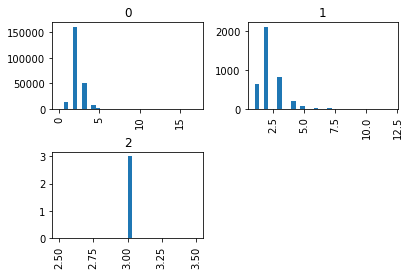

In [73]:
fulldata.hist(column="TOTAL_ACCEIDENTELEMENTS",by="SPEEDING_INVOLVED",bins=30)

array([[<AxesSubplot:title={'center':'TOTAL_INJURIES_ELEMENTS'}, xlabel='Rate'>,
        <AxesSubplot:title={'center':'TOTAL_INJURIES'}, xlabel='Rate'>],
       [<AxesSubplot:title={'center':'TOTAL_ACCEIDENTELEMENTS'}, xlabel='Rate'>,
        <AxesSubplot:title={'center':'TOTAL_MAJORINJURIES'}, xlabel='Rate'>]],
      dtype=object)

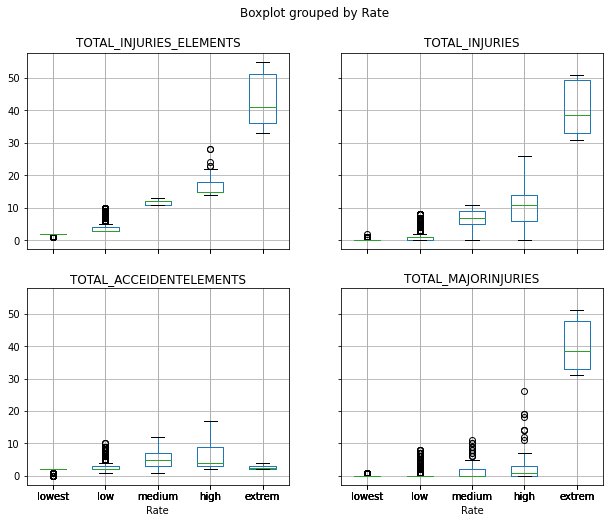

In [74]:
fulldata.boxplot(column=["TOTAL_INJURIES_ELEMENTS",'TOTAL_INJURIES', 'TOTAL_ACCEIDENTELEMENTS', 'TOTAL_MAJORINJURIES'],by="Rate", figsize=(10,8))

array([[<AxesSubplot:title={'center':'TOTAL_INJURIES_ELEMENTS'}, xlabel='INTAPPROACHDIRECTION'>,
        <AxesSubplot:title={'center':'TOTAL_FATAL'}, xlabel='INTAPPROACHDIRECTION'>],
       [<AxesSubplot:title={'center':'TOTAL_INJURIES'}, xlabel='INTAPPROACHDIRECTION'>,
        <AxesSubplot:title={'center':'TOTAL_ACCEIDENTELEMENTS'}, xlabel='INTAPPROACHDIRECTION'>]],
      dtype=object)

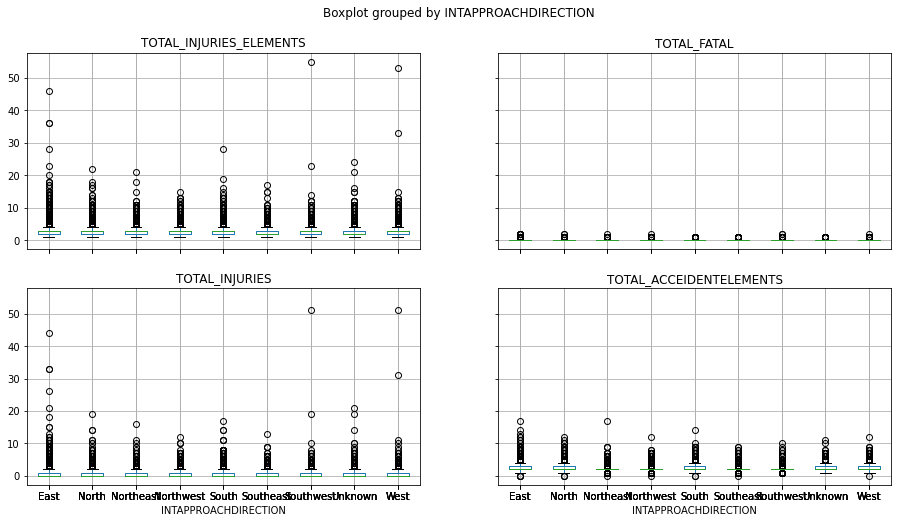

In [23]:
fulldata.boxplot(column=["TOTAL_INJURIES_ELEMENTS",'TOTAL_FATAL','TOTAL_INJURIES', 'TOTAL_ACCEIDENTELEMENTS'],by="INTAPPROACHDIRECTION", figsize=(15,8))

In [76]:
fulldata['TOTAL_INJURIES_ELEMENTS'].describe()

count    237193.000000
mean          2.727635
std           1.096224
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max          55.000000
Name: TOTAL_INJURIES_ELEMENTS, dtype: float64

# Export The data

In [24]:
fulldata.to_csv('/Volumes/LOVUN/George Mason Files/Fall 2021/AIT 614/project/data/Nov21_datasset.csv')

In [36]:
fulldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237956 entries, 647 to 257970
Data columns (total 54 columns):
 #   Column                      Non-Null Count   Dtype              
---  ------                      --------------   -----              
 0   X                           237956 non-null  float64            
 1   Y                           237956 non-null  float64            
 2   OBJECTID                    237956 non-null  object             
 3   CRIMEID                     237956 non-null  object             
 4   CCN                         237956 non-null  object             
 5   REPORTDATE                  237956 non-null  datetime64[ns, UTC]
 6   ROUTEID                     237956 non-null  object             
 7   MEASURE                     237956 non-null  float64            
 8   OFFSET                      237956 non-null  float64            
 9   FROMDATE                    237956 non-null  datetime64[ns, UTC]
 10  MARID                       237956 non-nul